Driver Consistency Score
Goal: Create a simple metric to rank drivers based on consistency across laps in a race.

In [6]:
import fastf1
import pandas as pd
import os
import numpy as np

In [ ]:
# Specify the cache directory path
cache_dir = 'fastf1_cache'

# Create the directory if it doesn't exist
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Enable caching
fastf1.Cache.enable_cache(cache_dir)

# Set the season and race you want to analyze
season = 2025
race_name = 'British Grand Prix'  # Change to the desired race

# Load the session data
session = fastf1.get_session(season, race_name, 'R')

# Load the session data
session.load()

# Extract lap data
laps = session.laps

# Create a DataFrame from the laps data
lap_data = pd.DataFrame({
    'Driver': laps['Driver'],
    'LapNumber': laps['LapNumber'],
    'LapTime': laps['LapTime'].dt.total_seconds(),
    'FormattedLapTime': laps['LapTime'].dt.components.minutes.astype(str) + ':' + (laps['LapTime'].dt.components.seconds.astype(str).str.zfill(2))
})

# Save the DataFrame to a CSV file
filename = f'{race_name.replace(" ", "_")}_lap_data_{season}.csv'
lap_data.to_csv(filename, index=False)
print(f"Lap data saved to {filename}")


core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

Lap data saved to British_Grand_Prix_lap_data_2025.csv


Data Preprocessing Steps


In [8]:
# Load the lap data from the CSV file
lap_data = pd.read_csv("British_Grand_Prix_lap_data_2025.csv")


In [9]:
# 1. Handle missing values: Replace empty LapTime or FormattedLapTime with NaN
lap_data['LapTime'] = pd.to_numeric(lap_data['LapTime'], errors='coerce')
lap_data['FormattedLapTime'] = lap_data['FormattedLapTime'].replace({'nan:nan': np.nan})


In [10]:

# 2. Remove laps with missing LapTime (e.g., in-laps, out-laps, or DNFs)
lap_data_clean = lap_data.dropna(subset=['LapTime'])


In [11]:

# 3. Convert LapNumber to integer (if not already)
lap_data_clean['LapNumber'] = lap_data_clean['LapNumber'].astype(int)


C:\Users\manpr\AppData\Local\Temp\ipykernel_14144\2597777068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_data_clean['LapNumber'] = lap_data_clean['LapNumber'].astype(int)


In [12]:

# 4. Reset index after cleaning
lap_data_clean = lap_data_clean.reset_index(drop=True)


In [13]:
# 5.Preview the cleaned data
print("Preview of cleaned lap data:")
print(lap_data_clean.head())


Preview of cleaned lap data:
  Driver  LapNumber  LapTime FormattedLapTime
0    VER          1  105.820         1.0:45.0
1    VER          2  135.598         2.0:15.0
2    VER          3  137.357         2.0:17.0
3    VER          4  105.568         1.0:45.0
4    VER          5  104.809         1.0:44.0


In [14]:
# Calculate standard deviation of lap times per driver
lap_time_std_per_driver = lap_data.groupby('Driver')['LapTime'].std().reset_index()
lap_time_std_per_driver.rename(columns={'LapTime': 'LapTimeStdDev'}, inplace=True)

# Sort to show most consistent drivers first (lowest std deviation)
lap_time_std_per_driver = lap_time_std_per_driver.sort_values(by='LapTimeStdDev')

# Display
print(lap_time_std_per_driver)


   Driver  LapTimeStdDev
4     BOR       1.306581
2     ANT      12.358603
17    STR      12.690719
9     HUL      12.762098
19    VER      12.820842
14    PIA      12.986957
12    NOR      13.025495
16    SAI      13.777018
13    OCO      13.988407
6     GAS      14.037520
18    TSU      14.194221
0     ALB      14.220869
3     BEA      14.291132
8     HAM      14.318981
1     ALO      14.461444
7     HAD      14.485854
15    RUS      14.617385
11    LEC      14.863676
5     COL            NaN
10    LAW            NaN


Calculate standard deviation of lap times per drive

In [15]:
# Step 1: Calculate standard deviation of lap times per driver
lap_time_std = (
    lap_data.groupby('Driver')['LapTime']
    .std()
    .reset_index()
    .rename(columns={'LapTime': 'LapTimeStdDev'})
)

# Step 2: Create consistency score (inverse of std dev)
lap_time_std['ConsistencyScore'] = 1 / lap_time_std['LapTimeStdDev']

# Step 3: Sort drivers by consistency score (higher = more consistent)
lap_time_std = lap_time_std.sort_values(by='ConsistencyScore', ascending=False)

# Show results
print(lap_time_std)


   Driver  LapTimeStdDev  ConsistencyScore
4     BOR       1.306581          0.765356
2     ANT      12.358603          0.080915
17    STR      12.690719          0.078798
9     HUL      12.762098          0.078357
19    VER      12.820842          0.077998
14    PIA      12.986957          0.077000
12    NOR      13.025495          0.076773
16    SAI      13.777018          0.072585
13    OCO      13.988407          0.071488
6     GAS      14.037520          0.071238
18    TSU      14.194221          0.070451
0     ALB      14.220869          0.070319
3     BEA      14.291132          0.069973
8     HAM      14.318981          0.069837
1     ALO      14.461444          0.069149
7     HAD      14.485854          0.069033
15    RUS      14.617385          0.068412
11    LEC      14.863676          0.067278
5     COL            NaN               NaN
10    LAW            NaN               NaN


In [16]:
# Step 1: Calculate standard deviation of lap times per driver
lap_time_std = (
    lap_data.groupby('Driver')['LapTime']
    .std()
    .reset_index()
    .rename(columns={'LapTime': 'LapTimeStdDev'})
)

# Step 2: Create consistency score (inverse of std dev)
lap_time_std['ConsistencyScore'] = 1 / lap_time_std['LapTimeStdDev']

# Step 3: Rank drivers (higher consistency score = better rank)
lap_time_std['Rank'] = lap_time_std['ConsistencyScore'].rank(ascending=False)

# Step 4: Sort by rank
lap_time_std = lap_time_std.sort_values(by='Rank')

# Show final ranked table
print(lap_time_std[['Driver', 'LapTimeStdDev', 'ConsistencyScore', 'Rank']])

   Driver  LapTimeStdDev  ConsistencyScore  Rank
4     BOR       1.306581          0.765356   1.0
2     ANT      12.358603          0.080915   2.0
17    STR      12.690719          0.078798   3.0
9     HUL      12.762098          0.078357   4.0
19    VER      12.820842          0.077998   5.0
14    PIA      12.986957          0.077000   6.0
12    NOR      13.025495          0.076773   7.0
16    SAI      13.777018          0.072585   8.0
13    OCO      13.988407          0.071488   9.0
6     GAS      14.037520          0.071238  10.0
18    TSU      14.194221          0.070451  11.0
0     ALB      14.220869          0.070319  12.0
3     BEA      14.291132          0.069973  13.0
8     HAM      14.318981          0.069837  14.0
1     ALO      14.461444          0.069149  15.0
7     HAD      14.485854          0.069033  16.0
15    RUS      14.617385          0.068412  17.0
11    LEC      14.863676          0.067278  18.0
5     COL            NaN               NaN   NaN
10    LAW           

In [21]:
# Calculate the correlation between average lap time and lap time standard deviation per driver

# Step 1: Calculate average lap time per driver
lap_time_mean = (
    lap_data.groupby('Driver')['LapTime']
    .mean()
    .reset_index()
    .rename(columns={'LapTime': 'LapTimeMean'})
)

# Step 2: Merge with standard deviation table
lap_time_stats = pd.merge(lap_time_mean, lap_time_std[['Driver', 'LapTimeStdDev']], on='Driver')

# Step 3: Calculate correlation
correlation = lap_time_stats['LapTimeMean'].corr(lap_time_stats['LapTimeStdDev'])

print("Correlation between average lap time and lap time standard deviation per driver:", correlation)


Correlation between average lap time and lap time standard deviation per driver: -0.7834744979274242


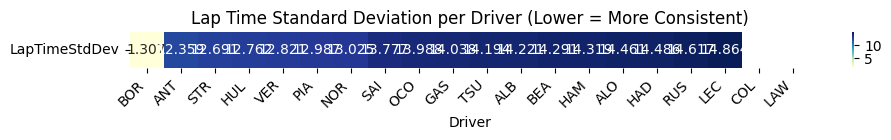

C:\Users\manpr\AppData\Local\Temp\ipykernel_14144\2722153563.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


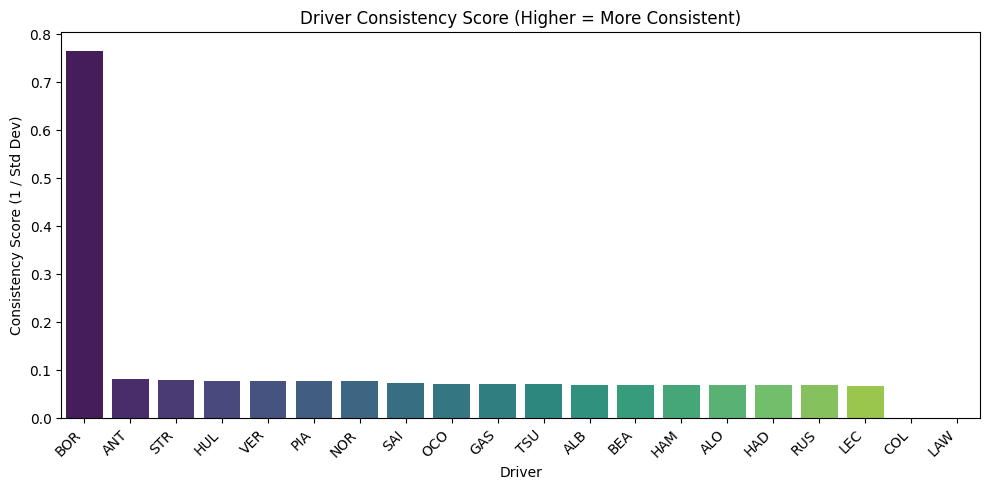

C:\Users\manpr\AppData\Local\Temp\ipykernel_14144\2722153563.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


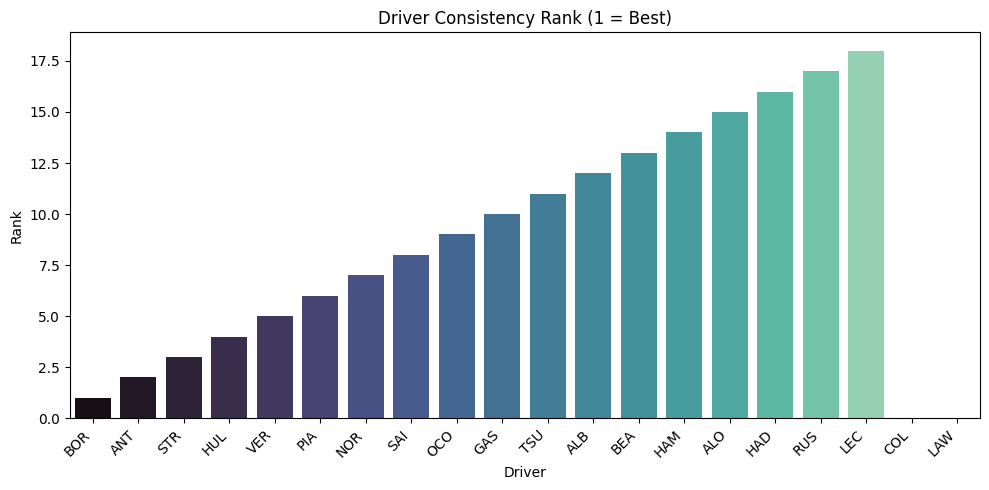

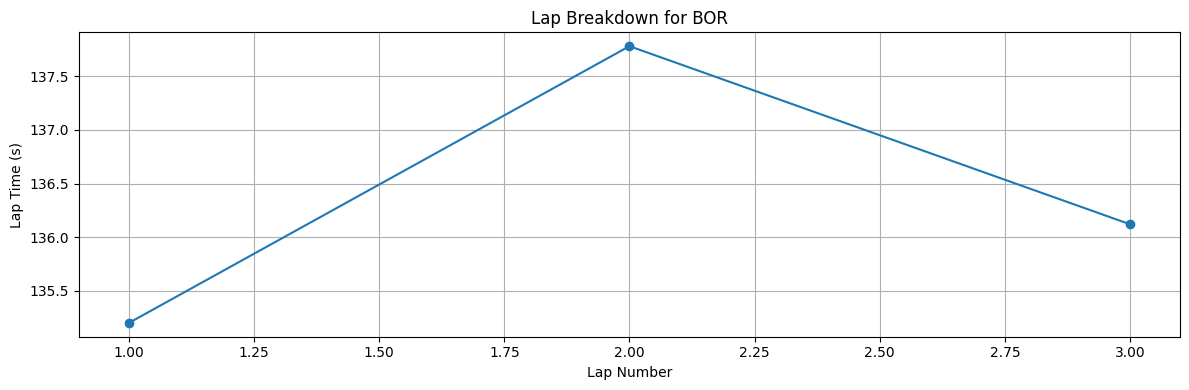

,LapNumber,LapTime
0,1.0,135.202
1,2.0,137.780
2,3.0,136.121
3,4.0,NaN


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Heatmap: Lap Time Standard Deviation per Driver ---
plt.figure(figsize=(10, 1.5))
# Prepare data for heatmap: 1 row, drivers as columns
stddev_matrix = lap_time_std.set_index('Driver')[['LapTimeStdDev']].T
sns.heatmap(stddev_matrix, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Lap Time Standard Deviation per Driver (Lower = More Consistent)")
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Bar Graph: Consistency Score Ranking ---
plt.figure(figsize=(10, 5))
sorted_scores = lap_time_std.sort_values('Rank')
sns.barplot(
    data=sorted_scores,
    x='Driver',
    y='ConsistencyScore',
    palette='viridis'
)
plt.title("Driver Consistency Score (Higher = More Consistent)")
plt.ylabel("Consistency Score (1 / Std Dev)")
plt.xlabel("Driver")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Bar Graph: Rank by Consistency Score ---
plt.figure(figsize=(10, 5))
sns.barplot(
    data=sorted_scores,
    x='Driver',
    y='Rank',
    palette='mako'
)
plt.title("Driver Consistency Rank (1 = Best)")
plt.ylabel("Rank")
plt.xlabel("Driver")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Lap Breakdown Example for a Modal (Single Driver) ---
# Pick a driver to show breakdown (e.g., top ranked)
top_driver = sorted_scores.iloc[0]['Driver']
driver_laps = lap_data[lap_data['Driver'] == top_driver].sort_values('LapNumber')

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(driver_laps['LapNumber'], driver_laps['LapTime'], marker='o', label='Lap Time')
ax1.set_title(f"Lap Breakdown for {top_driver}")
ax1.set_xlabel("Lap Number")
ax1.set_ylabel("Lap Time (s)")
ax1.grid(True)
plt.tight_layout()
plt.show()

# Table: Show lap breakdown as a DataFrame
display(driver_laps[['LapNumber', 'LapTime']].reset_index(drop=True))
